In this notebook we will classify dog images into breeds with a MLP and two different CNNs. We will also discuss choices in the design process of these models.

# Unzip Dataset Files

Requires `archive.zip` from Kaggle. The resulting data should be extracted in `dataset` folder, which includes 10 sub-folders (one for each dog breed).

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: dataset/Beagle/Beagle_1.jpg  
  inflating: dataset/Beagle/Beagle_10.jpg  
  inflating: dataset/Beagle/Beagle_100.jpg  
  inflating: dataset/Beagle/Beagle_11.jpg  
  inflating: dataset/Beagle/Beagle_12.jpg  
  inflating: dataset/Beagle/Beagle_13.jpg  
  inflating: dataset/Beagle/Beagle_14.jpg  
  inflating: dataset/Beagle/Beagle_15.jpg  
  inflating: dataset/Beagle/Beagle_16.jpg  
  inflating: dataset/Beagle/Beagle_17.jpg  
  inflating: dataset/Beagle/Beagle_18.jpg  
  inflating: dataset/Beagle/Beagle_19.jpg  
  inflating: dataset/Beagle/Beagle_2.jpg  
  inflating: dataset/Beagle/Beagle_20.jpg  
  inflating: dataset/Beagle/Beagle_21.jpg  
  inflating: dataset/Beagle/Beagle_22.jpg  
  inflating: dataset/Beagle/Beagle_23.jpg  
  inflating: dataset/Beagle/Beagle_24.jpg  
  inflating: dataset/Beagle/Beagle_25.jpg  
  inflating: dataset/Beagle/Beagle_26.jpg  
  inflating: dataset/Beagle/Beagle_27.jpg  
  inflating: dataset/Beagle/Beagle_28.jpg  
  inflating

# Import Libraries

* PIL library is used to load the images.
* Tensorflow is used as the Neural Network engine.

In [ ]:
import os
import PIL
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load Class Names

Loading the class ids according to the folder names.

In [ ]:
class_names = sorted(os.listdir('dataset'))
class_ids = {label: i for i, label in enumerate(class_names)}
class_ids

{'Beagle': 0,
 'Boxer': 1,
 'Bulldog': 2,
 'Dachshund': 3,
 'German_Shepherd': 4,
 'Golden_Retriever': 5,
 'Labrador_Retriever': 6,
 'Poodle': 7,
 'Rottweiler': 8,
 'Yorkshire_Terrier': 9}

# Load & Display Image

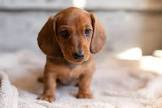

In [ ]:
image_filepath = 'dataset/Dachshund/Dachshund_34.jpg'
image = PIL.Image.open(image_filepath)
image

# Load & Preprocess Images

Loads 967 images RGB images (3 channels), each one resized at (64,64). The target breeds are encoded as integers, according to their class id.

In [ ]:
image_size = (64, 64)

inputs = []
targets = []
for label in class_names:
    for filename in os.listdir(f'dataset/{label}'):
        filepath = f'dataset/{label}/{filename}'
        img = PIL.Image.open(filepath).convert('RGB').resize(image_size)
        inputs.append(img)
        targets.append(class_ids[label])
inputs = np.float32(inputs)
targets = np.int32(targets)

inputs.shape, targets.shape

((967, 64, 64, 3), (967,))

# Plot Target Distribution

<BarContainer object of 10 artists>

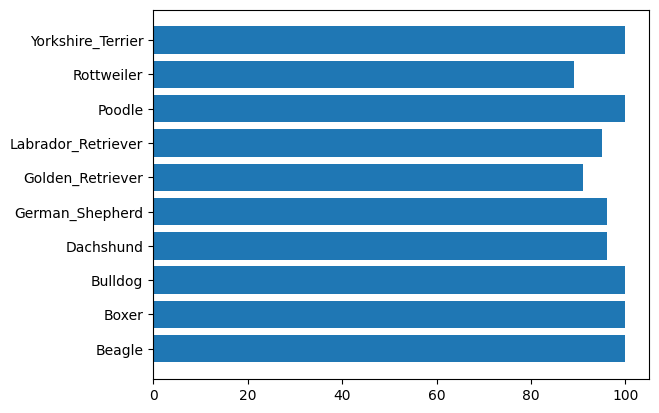

In [ ]:
target_counts = np.unique(targets, return_counts=True)
plt.barh(class_names, target_counts[1])

# Setting Seeds To Enable Reproducability

In [ ]:
seed = 0

tf.random.set_seed(seed=seed)
np.random.seed(seed=seed)
random.seed(seed)

# Split Inputs into Train-Test-Val with Stratify Option

We will split in 60%-20%-20 for training, testing and validation, as it is not a good practice to test on the validation set.

In [ ]:
# Spliting in 60%-20%-20 for training, testing and evaluation

x_train, x_temp, y_train, y_temp = train_test_split(
    inputs,
    targets,
    test_size=0.4,
    stratify=targets,
    random_state=seed
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=seed
)

# Preprocessing Dataset

1. Normalizing inputs in [0.0, 1.0] by dividing with 255.0 (Min Pixel value is 0.0, Max Pixel value is 255.0).
2. One-Hot encoding targets to enable the use of Softmax Activation Function.

In [ ]:
x_train /= 255.0
x_test /= 255.0
x_val /=255.0
y_train = np.eye(len(class_names))[y_train]
y_test = np.eye(len(class_names))[y_test]
y_val = np.eye(len(class_names))[y_val]

y_train.shape, y_test.shape, y_val.shape

((580, 10), (194, 10), (193, 10))

# Building Multi-Layer Perceptron

* Input: (128, 128, 3) which is flattened into a vector.
* Output: 10 (same as number of classes).

In [ ]:
input_size = x_train.shape[1:]
output_size = len(class_names)

mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='MLP')
mlp.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,794 (6.07 MB)

 Trainable params: 1,590,794 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

# Training Neural Network

* Optimizer: Adam
* Learning Rate: 0.001
* Loss Function: Categorical Cross-Entropy
* Metrics: Accuracy
* Batch Size: 32
* Epochs: 30

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
mlp.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 30

history = mlp.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.1393 - loss: 3.4291 - val_accuracy: 0.2798 - val_loss: 2.1989
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2759 - loss: 2.1078 - val_accuracy: 0.2953 - val_loss: 2.0987
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2571 - loss: 2.0730 - val_accuracy: 0.2642 - val_loss: 2.0650
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3062 - loss: 1.8623 - val_accuracy: 0.3627 - val_loss: 1.7165
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4598 - loss: 1.5763 - val_accuracy: 0.5078 - val_loss: 1.5780
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5854 - loss: 1.3163 - val_accuracy: 0.5492 - val_loss: 1.4779
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5975 - loss: 1.2415 - val_accuracy: 0.4715 - val_loss: 1.4209
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6508 - loss: 1.0934 - val_accuracy: 0.5855 - val_l

# Evaluating Model Performance Per Epoch

1. Train-Test Loss
2. Train-Test Accuracy

In [ ]:
y_pred = mlp.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), y_pred_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
              precision    recall  f1-score     support
0              0.909091  1.000000  0.952381   20.000000
1              1.000000  1.000000  1.000000   20.000000
2              1.000000  1.000000  1.000000   20.000000
3              0.894737  0.894737  0.894737   19.000000
4              1.000000  0.900000  0.947368   20.000000
5              1.000000  1.000000  1.000000   18.000000
6              1.000000  1.000000  1.000000   19.000000
7              0.818182  0.900000  0.857143   20.000000
8              1.000000  0.888889  0.941176   18.000000
9              1.000000  1.000000  1.000000   20.000000
accuracy       0.958763  0.958763  0.958763    0.958763
macro avg      0.962201  0.958363  0.959281  194.000000
weighted avg   0.961575  0.958763  0.959170  194.000000


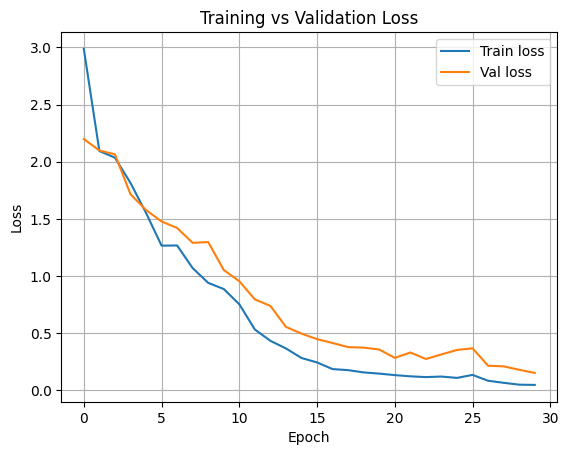

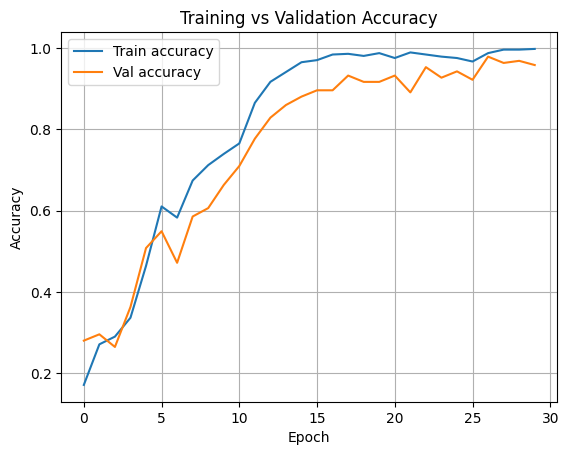

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Building Convolutional Neural Network

In [ ]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', use_bias=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', use_bias=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='CNN')
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 31, 31, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,298 (13.18 MB)

 Trainable params: 3,456,298 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

# Training CNN

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.1281 - loss: 2.4117 - val_accuracy: 0.3575 - val_loss: 2.1736
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3237 - loss: 2.0766 - val_accuracy: 0.4715 - val_loss: 1.7331
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5477 - loss: 1.4654 - val_accuracy: 0.6114 - val_loss: 1.1876
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7553 - loss: 0.8528 - val_accuracy: 0.6943 - val_loss: 0.9192
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8655 - loss: 0.4858 - val_accuracy: 0.9378 - val_loss: 0.3289
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9632 - loss: 0.1989 - val_accuracy: 0.9585 - val_loss: 0.1855
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9895 - loss: 0.0817 - val_accuracy: 0.9689 - val_loss: 0.1405
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9979 - loss: 0.0604 - val_accuracy: 0.9741 - val_lo

# Evaluating Model Performance Per Epoch

1. Train-Test Loss
2. Train-Test Accuracy

In [ ]:
y_pred = cnn.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), y_pred_labels, output_dict=True)
df_cnn = pd.DataFrame(report).transpose()
print(df_cnn)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   20.000000
1              0.909091  1.000000  0.952381   20.000000
2              1.000000  1.000000  1.000000   20.000000
3              0.904762  1.000000  0.950000   19.000000
4              1.000000  1.000000  1.000000   20.000000
5              1.000000  1.000000  1.000000   18.000000
6              1.000000  1.000000  1.000000   19.000000
7              1.000000  0.900000  0.947368   20.000000
8              1.000000  0.888889  0.941176   18.000000
9              1.000000  1.000000  1.000000   20.000000
accuracy       0.979381  0.979381  0.979381    0.979381
macro avg      0.981385  0.978889  0.979093  194.000000
weighted avg   0.981300  0.979381  0.979310  194.000000


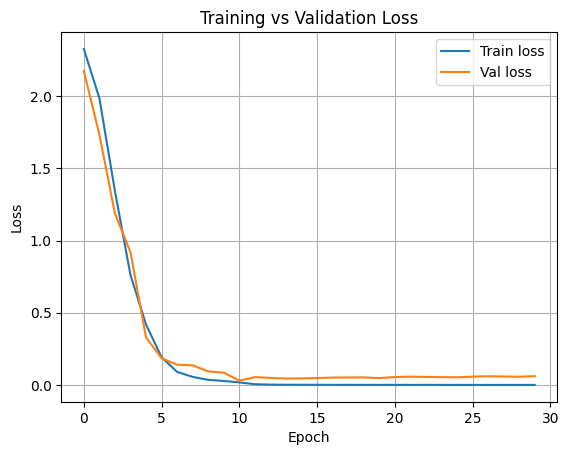

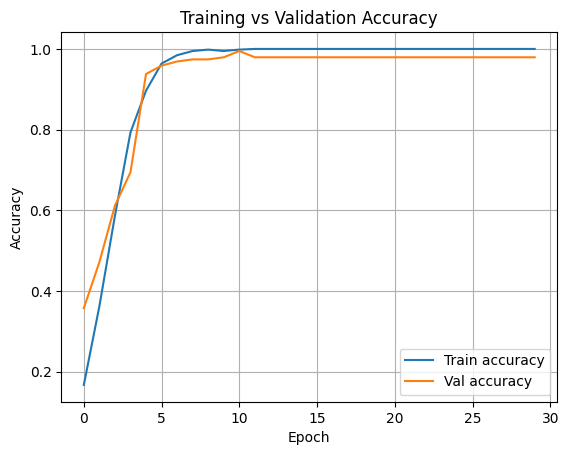

In [ ]:
plt.figure()
plt.plot(history_cnn.history['loss'], label='Train loss')
plt.plot(history_cnn.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history_cnn.history['accuracy'], label='Train accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

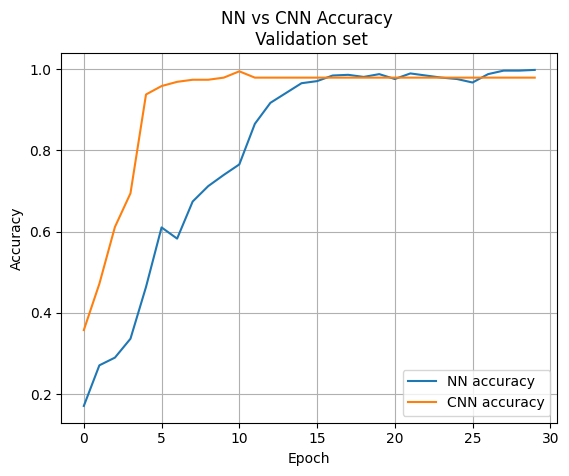

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='NN accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('NN vs CNN Accuracy \n Validation set')
plt.legend()
plt.grid(True)
plt.show()

# MLP vs CNN Comparison

The CNN model seems to be better than the MLP, but not by much. Its accuracy is higher and its f1-scores are better and more consistent in many classes.

# Imrpove CNN

To improve the architecture we will scale the data with the standard scaler and not the min-max approach, as outliers can have a negative effect in the scaling process. In addition, we will add more CNN layers with an increasing filter size to capture more information. Moreover, we will add Batch Normalization Max Pooling and Dropout layers, while pushing the activation afterwards, making the model more stable, faster and reducing parameterers efficiently.

In [ ]:
# Spliting in 60%-20%-20 for training, testing and validation

x_train, x_temp, y_train, y_temp = train_test_split(
    inputs,
    targets,
    test_size=0.4,
    stratify=targets,
    random_state=seed
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=seed
)

y_train = np.eye(len(class_names))[y_train]
y_test = np.eye(len(class_names))[y_test]
y_val = np.eye(len(class_names))[y_val]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape


((580, 64, 64, 3),
 (580, 10),
 (194, 64, 64, 3),
 (194, 10),
 (193, 64, 64, 3),
 (193, 10))

In [ ]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)
x_val_reshaped = x_val.reshape(x_val.shape[0], -1)

x_train_reshaped.shape, y_train.shape, x_test_reshaped.shape, y_test.shape, x_val_reshaped.shape

((580, 12288), (580, 10), (194, 12288), (194, 10), (193, 12288))

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)
x_val_scaled = scaler.transform(x_val_reshaped)

In [ ]:
x_train_final =x_train_scaled.reshape(x_train.shape[0],64,64,3)
x_test_final =x_test_scaled.reshape(x_test.shape[0],64,64,3)
x_val_final =x_val_scaled.reshape(x_val.shape[0],64,64,3)
x_train_final.shape, y_train.shape, x_test_final.shape, y_test.shape, x_val_final.shape

((580, 64, 64, 3), (580, 10), (194, 64, 64, 3), (194, 10), (193, 64, 64, 3))

In [ ]:
cnn2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64,64,3)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='CNN')
cnn2.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,468,874 (32.31 MB)

 Trainable params: 8,467,978 (32.30 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn2.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
epochs = 100
history_cnn = cnn2.fit(
    x_train_final,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val_final, y_val)
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9994 - loss: 0.0218 - val_accuracy: 0.8549 - val_loss: 0.8635
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9913 - loss: 0.0472 - val_accuracy: 0.8394 - val_loss: 0.6627
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 0.9689 - val_loss: 0.1743
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9793 - val_loss: 0.1111
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.9787e-04 - val_accuracy: 0.9845 - val_loss: 0.0917
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.7643e-04 - val_accuracy: 0.9845 - val_loss: 0.0801
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 4.8347e-04 - val_accuracy: 0.9845 - val_loss: 0.0724
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.5345e-04 

In [ ]:
y_pred = cnn2.predict(x_test_final)
y_pred_labels = np.argmax(y_pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), y_pred_labels, output_dict=True)
df_cnn_2 = pd.DataFrame(report).transpose()
print(df_cnn_2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   20.000000
1              1.000000  1.000000  1.000000   20.000000
2              1.000000  1.000000  1.000000   20.000000
3              1.000000  1.000000  1.000000   19.000000
4              0.909091  1.000000  0.952381   20.000000
5              1.000000  1.000000  1.000000   18.000000
6              1.000000  1.000000  1.000000   19.000000
7              0.900000  0.900000  0.900000   20.000000
8              1.000000  0.888889  0.941176   18.000000
9              1.000000  1.000000  1.000000   20.000000
accuracy       0.979381  0.979381  0.979381    0.979381
macro avg      0.980909  0.978889  0.979356  194.000000
weighted avg   0.980319  0.979381  0.979324  194.000000


In general we see similar performance with the previous cnn, which was already very accurate. This could be an indication of the simplicity of the problem, or of the fact that the original CNN was strong enough to deal with this classification task. The more complex the model, the more difficult the problem should be. Thus, we could increase the dataset size (if we have more data) or change more training parameters (like number of epochs or add an adjustable learning rate) to evaluate the complex cnn in a more fair way.